# **Global Wheat Detection**
(Kaggle. 2020. Global Wheat Detection Competition. Retrieved from https://www.kaggle.com/c/global-wheat-detection)
<br>
<br>


The Global Wheat Detection competition focuses on detecting wheat heads in outdoor images to improve data on wheat density and size across varieties worldwide. Accurate wheat head detection is critical for farmers and researchers to assess crop health, maturity, and yield. However, challenges arise due to overlapping plants, blurred images, variations in genotype, color, and maturity, and diverse global growing conditions.  

The competition uses the **Global Wheat Head Dataset**, developed by nine research institutes from seven countries and supported by organizations like the Global Institute for Food Security and DigitAg. Participants aim to create generalized detection models capable of working across varied environments. Training data includes 3,000 images from Europe (France, UK, Switzerland) and North America (Canada), while the test set features 1,000 images from Australia, Japan, and China.   

By addressing the visual and environmental challenges in wheat head detection, the competition seeks to enhance wheat phenotyping, benefiting farmers worldwide and ensuring more informed crop management.

## Evaluation

The competition evaluates performance using mean average precision (mAP) across a range of Intersection over Union (IoU) thresholds (from 0.5 to 0.75 with steps of 0.05). IoU measures overlap between predicted and ground truth bounding boxes, with predictions considered correct if the IoU exceeds a threshold. Precision is calculated based on true positives (correct predictions), false positives (extra predictions), and false negatives (missed detections). The average precision for each image is the mean precision over all IoU thresholds, and the competition score is the mean of these values across the test dataset.   

Submissions must include confidence scores for bounding boxes, which are used to rank predictions and evaluate their accuracy.   

Images without ground truth objects penalize incorrect predictions with a zero score.

## Intersection over Union (IoU)

Intersection over Union is a measure of the magnitude of overlap between two bounding boxes (or, in the more general case, two objects). It calculates the size of the overlap between two objects, divided by the total area of the two objects combined.

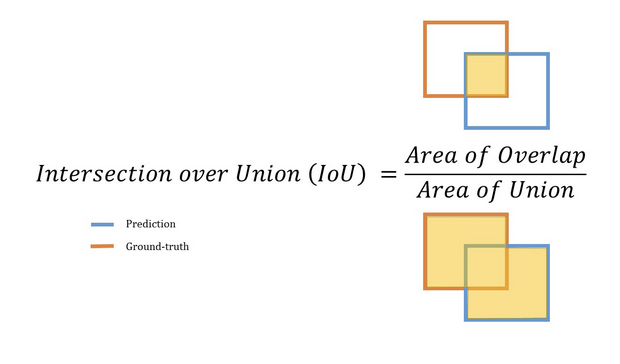

The two boxes in the visualization overlap, but the area of the overlap is insubstantial compared with the area taken up by both objects together. IoU would be low - and would likely not count as a "hit" at higher IoU thresholds.

## Submission File

The submission format requires a space delimited set of bounding boxes. For example:

ce4833752,0.5 0 0 100 100

indicates that image ce4833752 has a bounding box with a confidence of 0.5, at x == 0 and y == 0, with a width and height of 100.

The file should contain a header and have the following format. Each row in your submission should contain ALL bounding boxes for a given image.

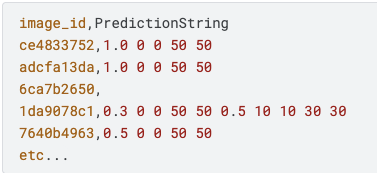


## Downloading the Dataset

Dataset Source: https://www.kaggle.com/competitions/global-wheat-detection

Before attempting to download the dataset, you have to get your kaggle API key and your kaggle username and set it to the google colab secrets as "KAGGLE_USERNAME" and "KAGGLE_KEY".

In [ ]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set up Kaggle API authentication

import os
from google.colab import userdata
import zipfile

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate Kaggle API
api = KaggleApi()
api.authenticate()

print("Kaggle API authenticated successfully!")

In [ ]:
# Ensure dataset is downloaded via Kaggle API
!kaggle competitions download -c global-wheat-detection -p /content/

# Extract the dataset and verify extraction

import zipfile

# Path to the downloaded dataset
zip_path = '/content/global-wheat-detection.zip'
extract_to = '/content/global-wheat-detection'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to: {extract_to}")

---
# Exploratory Data Analysis (EDA)

We perform an EDA for the dataset to gain insight s into the structures, distribution and patterns of the data, as well as prepare for building a reliable model.

## Dataset - Basic Overview

**Files**

- train.csv - the training data
- sample_submission.csv - a sample submission file in the correct format
- train.zip - training images
- test.zip - test images

<br>


First, we have to load and inspect the train.csv file to understand the structure of the dataset.

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data set
# adjust the path as needed if not in /content/

dataset_path = '/content/global-wheat-detection/train.csv'                      # Ensure dataset is downloaded via Kaggle API
train_df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print(train_df.head())

In [ ]:
# Summary of the dataset
print("\nDataset Info:")
print(train_df.info())

**Columns**

- image_id - the unique image ID
- width, height - the width and height of the images
- bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
- source - likely indicates the source of the data

In [ ]:
# Dataset description
print("\nDataset Description:")
print(train_df.describe())

In [ ]:
# Missing data/ duplicates

# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values)

# Check for duplicates
duplicates = train_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

**Data Statistics**

- Apparently, we have 147793 samples with 5 features.
- The image size is 1024 * 1024.
- There are no missing values or duplicates.

## Bounding Box Analysis

### Bounding Boxes - Basic Analysis

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import cv2
import os
from matplotlib.patches import Rectangle

import pandas.io.formats.style

In [ ]:
# Inspect the first few rows of the bbox column
print(train_df['bbox'].head())

# Check the type of each bbox entry
print(train_df['bbox'].apply(type).unique())

In [ ]:
# (Health)Check

# Analyze images with no bounding boxes
images_with_no_boxes = len(train_df[train_df['bbox'].isnull()])
total_images = train_df['image_id'].nunique()
images_with_boxes = total_images - images_with_no_boxes

print(f"\nTotal Images: {total_images}")
print(f"Images with Bounding Boxes: {images_with_boxes}")
print(f"Images without Bounding Boxes: {images_with_no_boxes}")

In [ ]:
# Analyze the number of images in the folder vs CSV file
image_folder =  '/content/train'                                                # Updated path
image_files = [f.split('.')[0] for f in os.listdir(image_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
images_in_folder_count = len(image_files)
images_in_csv_count = train_df['image_id'].nunique()

print(f"\nNumber of images in the folder '{image_folder}': {images_in_folder_count}")
print(f"Number of unique images in the CSV file: {images_in_csv_count}")

In [ ]:
# List images present in the CSV but missing in the folder
missing_images = set(train_df['image_id'].unique()) - set(image_files)
print(f"\nImages in CSV but missing in the folder: {len(missing_images)}")
print(missing_images)

In [ ]:
# List images present in the folder but not in the CSV
extra_images = set(image_files) - set(train_df['image_id'].unique())
print(f"\nImages in the folder but not in the CSV: {len(extra_images)}")
print(extra_images)

In [ ]:
# Analyze sources

# Count occurrences of each source
source_counts = train_df['source'].value_counts()

# Bar plot of data sources
source_counts.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Number of Bounding Boxes')
plt.title('Bounding Boxes by Source')
plt.show()

In [ ]:
# Count bounding boxes per image
bbox_count = train_df['image_id'].value_counts()
print("\nBounding Boxes per Image Statistics:")
print(bbox_count.describe())

In [ ]:
# Plot distribution of bounding boxes per image
plt.figure(figsize=(10, 6))
sns.histplot(bbox_count, kde=False, bins=30, color='green')
plt.title('Distribution of Bounding Boxes per Image')
plt.xlabel('Number of Bounding Boxes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Distribution of bounding boxes
import matplotlib.pyplot as plt
import ast

# Convert bbox column from string to list
train_df['bbox'] = train_df['bbox'].apply(ast.literal_eval)

# Extract box width and height
train_df['box_width'] = train_df['bbox'].apply(lambda x: x[2])                  # Width is at index 2
train_df['box_height'] = train_df['bbox'].apply(lambda x: x[3])                 # Height is at index 3

# Verify the transformation
print(train_df[['bbox', 'box_width', 'box_height']].head())


# Plot distribution of bounding box dimensions
plt.figure(figsize=(10, 6))
sns.histplot(train_df['box_width'], kde=True, bins=30, color='blue', label='Box Width')
sns.histplot(train_df['box_height'], kde=True, bins=30, color='orange', label='Box Height')
plt.title('Distribution of Bounding Box Dimensions')
plt.xlabel('Bounding Box Dimensions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Visualize an image with bounding boxes
import os
import cv2
import matplotlib.pyplot as plt

def visualize_image_with_bboxes(image_id, data, image_dir):
    """
    Visualize an image with bounding boxes.
    Parameters:
        image_id (str): The ID of the image to visualize.
        data (DataFrame): DataFrame containing bounding box information.
        image_dir (str): Directory where images are stored.
    """
    # Dynamically check for the correct file extension
    possible_extensions = ['jpg', 'png']
    image_path = None

    for ext in possible_extensions:
        temp_path = f"{image_dir}/{image_id}.{ext}"
        if os.path.exists(temp_path):
            image_path = temp_path
            break

    if image_path is None:
        print(f"Image {image_id} not found in {image_dir} with extensions {possible_extensions}")
        return

    # Read the image
    print(f"🔍 Looking for image at: {image_path}")
    image = cv2.imread(image_path)

    # Check if the image was read successfully
    if image is None:
        print(f"Failed to read image at {image_path}")
        return

    # Get bounding boxes for the image
    bboxes = data[data['image_id'] == image_id]['bbox'].values

    # Draw bounding boxes on the image
    for bbox in bboxes:
        x_min, y_min, width, height = bbox                                      # Unpack bounding box
        x_max = x_min + width
        y_max = y_min + height
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

# Visualization example
sample_image_id = train_df['image_id'].iloc[0]
image_dir = '/content/train'

visualize_image_with_bboxes(sample_image_id, train_df, image_dir)

In [ ]:
# Check which Data Type of 'bbox'
print(train_df['bbox'].head())
print(train_df['bbox'].apply(type).unique())                                    # Check the data types

In [ ]:
import numpy as np
import ast

# Ensure 'bbox' values are lists
def convert_bbox(value):
    if isinstance(value, str):                                                  # If it's a string, safely convert it
        return ast.literal_eval(value)
    elif isinstance(value, (list, tuple, np.ndarray)):                          # Already a list/array
        return value
    else:
        return None                                                             # Handle unexpected cases

# Apply conversion
train_df['bbox'] = train_df['bbox'].apply(convert_bbox)

# Extract x_min, y_min, width, and height
train_df['xmin'] = train_df['bbox'].apply(lambda x: x[0] if x else np.nan)
train_df['ymin'] = train_df['bbox'].apply(lambda x: x[1] if x else np.nan)
train_df['box_width'] = train_df['bbox'].apply(lambda x: x[2] if x else np.nan)
train_df['box_height'] = train_df['bbox'].apply(lambda x: x[3] if x else np.nan)

# Verify transformation
print(train_df[['bbox', 'xmin', 'ymin', 'box_width', 'box_height']].head())

In [ ]:
# Plot example bounding boxes for a few images
import cv2
import os
from matplotlib.patches import Rectangle

# Function to visualize bounding boxes on images
def visualize_bounding_boxes(image_id, df, image_folder='/content/train'):
    """Function to visualize bounding boxes on images."""
    image_path = os.path.join(image_folder, f"{image_id}.jpg")

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_id} not found in {image_folder}")
        return

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)

    for _, row in df[df['image_id'] == image_id].iterrows():
        xmin, ymin, width, height = row['xmin'], row['ymin'], row['box_width'], row['box_height']
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Bounding Boxes for {image_id}")
    plt.show()

# Visualize bounding boxes for a few random images
sample_images = train_df['image_id'].unique()[:3]
for image_id in sample_images:
    visualize_bounding_boxes(image_id, train_df)

### Bounding Boxes - Insights

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import cv2
import os
from matplotlib.patches import Rectangle

import pandas.io.formats.style

#### Aspect Ratio Analysis

In [ ]:
# Aspect Ratio Analysis
train_df['aspect_ratio'] = train_df['box_width'] / train_df['box_height']

# Summary of aspect ratios
print("\nAspect Ratio Statistics:")
print(train_df['aspect_ratio'].describe())

In [ ]:
# Inspect outliers in aspect ratios
extreme_aspect_ratios = train_df[(train_df['aspect_ratio'] > 10) | (train_df['aspect_ratio'] < 0.1)]
print("\nOutliers in Aspect Ratios:")
print(extreme_aspect_ratios)

# Display outliers as a table
import pandas.io.formats.style
styled_outliers = extreme_aspect_ratios.style.set_properties(**{'background-color': '#f9f9f9',
                                                                'color': 'black',
                                                                'border-color': 'black'})

In [ ]:
# Handling outliers: Filter out extreme aspect ratios
filtered_train_df = train_df[(train_df['aspect_ratio'] <= 10) & (train_df['aspect_ratio'] >= 0.1)]
print("\nFiltered Dataset Statistics:")
print(filtered_train_df['aspect_ratio'].describe())

In [ ]:
# Plot the distribution of aspect ratios after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_train_df['aspect_ratio'], kde=True, bins=100, color='green')
plt.title('Filtered Distribution of Aspect Ratios (Width / Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

#### Pixel Area Analysis

In [ ]:
# Pixel Area Analysis
train_df['pixel_area'] = train_df['box_width'] * train_df['box_height']

# Summary of pixel areas
print("\nPixel Area Statistics:")
print(train_df['pixel_area'].describe())

In [ ]:
# Ensure 'pixel_area' is calculated
train_df['pixel_area'] = train_df['box_width'] * train_df['box_height']

# Assuming all images have the same dimensions, use a predefined width and height
IMAGE_WIDTH = 1024                                                              # Modify based on dataset
IMAGE_HEIGHT = 1024                                                             # Modify based on dataset

# Compute image area
train_df['image_area'] = IMAGE_WIDTH * IMAGE_HEIGHT

# Compute coverage ratio
train_df['coverage_ratio'] = train_df['pixel_area'] / train_df['image_area']

# Verify the new column
print(train_df[['pixel_area', 'image_area', 'coverage_ratio']].head())

# Plot distribution of coverage ratios
plt.figure(figsize=(10, 6))
sns.histplot(train_df['coverage_ratio'], kde=True, bins=50, color='green')
plt.title('Distribution of Coverage Ratios (Bounding Box Area / Image Area)')
plt.xlabel('Coverage Ratio')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Inspect outliers in pixel areas (very small or very large areas)
pixel_area_outliers = train_df[(train_df['pixel_area'] < 10) | (train_df['pixel_area'] > 1e6)]
print("\nOutliers in Pixel Areas:")
print(pixel_area_outliers)

In [ ]:
# Dynamic threshold calculation for pixel area outliers
Q1 = train_df['pixel_area'].quantile(0.25)
Q3 = train_df['pixel_area'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

pixel_area_outliers_dynamic = train_df[(train_df['pixel_area'] < lower_bound) | (train_df['pixel_area'] > upper_bound)]
print("\nDynamic Outliers in Pixel Areas:")
print(pixel_area_outliers_dynamic)

In [ ]:
# Scatter plot of pixel area vs. aspect ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['aspect_ratio'], y=train_df['pixel_area'], alpha=0.6)
plt.title('Pixel Area vs. Aspect Ratio')
plt.xlabel('Aspect Ratio')
plt.ylabel('Pixel Area')
plt.show()

In [ ]:
# Relative area calculation (as % of image size)
train_df['relative_area'] = train_df['pixel_area'] / (train_df['box_width'].max() * train_df['box_height'].max())
print("\nRelative Area Statistics:")
print(train_df['relative_area'].describe())

In [ ]:
# Categorize bounding box sizes
train_df['size_category'] = pd.qcut(train_df['pixel_area'], q=3, labels=['small', 'medium', 'large'])
print("\nBounding Box Size Categories:")
print(train_df['size_category'].value_counts())

#### Edge Case Images  

In [ ]:
# Edge Case Images: Images with the most and fewest bounding boxes
edge_case_images = bbox_count.reset_index()
edge_case_images.columns = ['image_id', 'bbox_count']

# Display images with most and least bounding boxes
most_bboxes = edge_case_images.sort_values(by='bbox_count', ascending=False).head(5)
fewest_bboxes = edge_case_images.sort_values(by='bbox_count', ascending=True).head(5)

print("\nImages with Most Bounding Boxes:")
print(most_bboxes)

print("\nImages with Fewest Bounding Boxes:")
print(fewest_bboxes)

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to visualize an image with bounding boxes
def visualize_bounding_boxes(image_id, df, image_folder='/content/train'):
    image_path = os.path.join(image_folder, f"{image_id}.jpg")

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_id} not found in {image_folder}")
        return

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)

    # Get bounding boxes for the image
    for _, row in df[df['image_id'] == image_id].iterrows():
        xmin, ymin, width, height = row['xmin'], row['ymin'], row['box_width'], row['box_height']
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Bounding Boxes for {image_id} (Count: {len(df[df['image_id'] == image_id])})")
    plt.show()


# Define image IDs for visualization
most_bboxes_image_id = "35b935b6c"                                              # Image with the most bounding boxes (116)
fewest_bboxes_image_id = "79c8a1627"                                            # Image with the fewest bounding boxes (1)

# Visualize both images
visualize_bounding_boxes(most_bboxes_image_id, train_df)
visualize_bounding_boxes(fewest_bboxes_image_id, train_df)

# NOTE: This code snippet references specific image IDs from the Kaggle dataset.
# You must download the dataset yourself from Kaggle to execute this visualization.
# Dataset source: https://www.kaggle.com/competitions/global-wheat-detection

In [ ]:
# Image-Level Coverage
train_df['image_area'] = train_df['box_width'].max() * train_df['box_height'].max()
train_df['coverage_ratio'] = train_df['pixel_area'] / train_df['image_area']

# Summary of coverage ratio
print("\nCoverage Ratio Statistics:")
print(train_df['coverage_ratio'].describe())

In [ ]:
# Plot distribution of coverage ratios
plt.figure(figsize=(10, 6))
sns.histplot(train_df['coverage_ratio'], kde=True, bins=50, color='green')
plt.title('Distribution of Coverage Ratios (Bounding Box Area / Image Area)')
plt.xlabel('Coverage Ratio')
plt.ylabel('Frequency')
plt.show()